The MIT License (MIT)

Copyright © 2026 Martin Ladecký, Ivana Pultarová, François Bignonnet, Indre Jödicke, Jan Zeman, Lars Pastewka

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Sharp vs. Smooth Data
This notebook compares the performance of the Green, Jacobi, and Green-Jacobi preconditioners using an auxetic microstructure geometry. It is designed to evaluate how different material configurations and transitions affect solver convergence.

Key aspects covered:
1. **Preconditioner Comparison**: Evaluating Green, Jacobi, and Green-Jacobi (hybrid) methods.
2. **Sharp vs. Smooth Transitions**: Analyzing the impact of material interface sharpness on convergence.
3. **Phase Contrast**: Exploring the behavior of the solver across a range of material contrast ratios (from $10^{1}$ to $10^{5}$).

## Required Files
- `auxetic_microstructure_64.npy`: NumPy array containing the auxetic microstructure geometry (64×64 grid)

## Reference
This notebook accompanies the paper "Jacobi-accelerated FFT-based solver for smooth high-contrast data" and reproduces problem from Section 4.4. Smooth vs sharp interphases.

In [16]:
import numpy as np
import scipy as sc
import scipy.sparse.linalg as sp
import matplotlib.pyplot as plt
%matplotlib inline


## Utility Functions
Inlined from `mu_FEFFT` library.


In [17]:
def get_shape_function_gradients(discretization_type, pixel_size):
    """
    Returns the shape function gradients and quadrature weights for a single pixel.
    Currently supports 'linear_triangles'.
    """
    if discretization_type == 'linear_triangles':
        ndim = 2
        nb_quad = 2
        dx, dy = pixel_size
        # B(dim, quad_point, node_idx)
        B = np.zeros([ndim, nb_quad, 4])
        # first quad point
        B[:, 0, :] = [[-1 / dx, 0, 1 / dx, 0],
                      [-1 / dy, 1 / dy, 0, 0]]
        # second quad point
        B[:, 1, :] = [[0, -1 / dx, 0, 1 / dx],
                      [0, 0, -1 / dy, 1 / dy]]

        weights = np.array([dx * dy / 2, dx * dy / 2])
        return B.reshape(ndim, nb_quad, 2, 2), weights

def get_gradient_operators(pixel_size, N, dofs_per_node):
    """
    Creates and returns the gradient (B) and weighted divergence (Bw_t) operators
    for the given grid and discretization.
    """
    ndim = 2
    B_dqij, weights = get_shape_function_gradients('linear_triangles', pixel_size)
    nb_quad = weights.size

    def B_op(u_ixy):
        grad_u_ijqxy = np.zeros([dofs_per_node, ndim, nb_quad, *N])
        for pixel_node in np.ndindex(2, 2):
            grad_u_ijqxy += np.einsum('jq,ixy...->ijqxy...',
                                      B_dqij[(..., *pixel_node)],
                                      np.roll(u_ixy, -1 * np.array(pixel_node), axis=tuple(range(1, ndim + 1))),
                                      optimize='optimal')
        return grad_u_ijqxy

    def Bw_t_op(flux_ijqxyz):
        div_flux_ixy = np.zeros([dofs_per_node, *N])
        # apply quadrature weights
        flux_weighted = np.einsum('ijq...,q->ijq...', flux_ijqxyz, weights, optimize='optimal')
        for pixel_node in np.ndindex(2, 2):
            div_fnxyz_pixel_node = np.einsum('jq,ijqxy...->ixy...',
                                             B_dqij[(..., *pixel_node)],
                                             flux_weighted, optimize='optimal')
            div_flux_ixy += np.roll(div_fnxyz_pixel_node, 1 * np.array(pixel_node), axis=tuple(range(1, ndim + 1)))
        return div_flux_ixy

    return B_op, Bw_t_op, weights

def scale_field_log10(field, min_val, max_val):
    """Logarithmically scales a 2D field to be within [min_val, max_val]."""
    field_log = np.log10(field)
    field_min, field_max = np.min(field_log), np.max(field_log)
    # Normalize to [0,1]
    scaled_field = (field_log - field_min) / (field_max - field_min)
    # Scale to target log range and exponentiate
    return 10 ** (scaled_field * (np.log10(max_val) - np.log10(min_val)) + np.log10(min_val))

## Problem Parameters
Setup grid, loading, and material properties.


In [18]:
nb_quad_points_per_pixel = 2
ndim = 2
N_x = N_y = 64
N = (N_x, N_y)
domain_size = (1, 1)
domain_vol = np.prod(domain_size)
pixel_size = tuple(np.array(domain_size) / np.array(N))

# Load auxetic microstructure geometry
name = 'auxetic_microstructure_64'
try:
    geometry = np.load(f'./{name}.npy', allow_pickle=True)
except FileNotFoundError:
    try:
        geometry = np.load(f'../data/{name}.npy', allow_pickle=True)
    except FileNotFoundError:
        # Fallback if the notebook is run from a different location
        import os
        geometry = np.load(os.path.join('experiments/Paper:Jacobi-accelerated FFT/', f'{name}.npy'), allow_pickle=True)

# Auxiliary values
n_u_dofs = ndim
ndof = ndim * np.prod(np.array(N))
displacement_shape = (ndim,) + N
grad_shape = (ndim, ndim, nb_quad_points_per_pixel) + N

# Basic operators
dot21 = lambda A, v: np.einsum('ij...,j...->i...', A, v)
ddot42 = lambda A, B: np.einsum('ijkl...,lk...->ij...', A, B)
fft = lambda x: np.fft.fftn(x, [*N])
ifft = lambda x: np.fft.ifftn(x, [*N])

# Initialize gradient operators
B, Bw_t, quadrature_weights = get_gradient_operators(pixel_size, N, n_u_dofs)

# Define reference elasticity tensors
i_mat = np.eye(ndim)
I4s = (np.einsum('il,jk', i_mat, i_mat) + np.einsum('ik,jl', i_mat, i_mat)) / 2.
II = np.einsum('ij,kl', i_mat, i_mat)

K_0, mu_0 = 1.0, 55.5  # Bulk and shear modulus for matrix
K4_0 = K_0 * II + 2. * mu_0 * (I4s - 1. / 3. * II) # Stiffness tensor


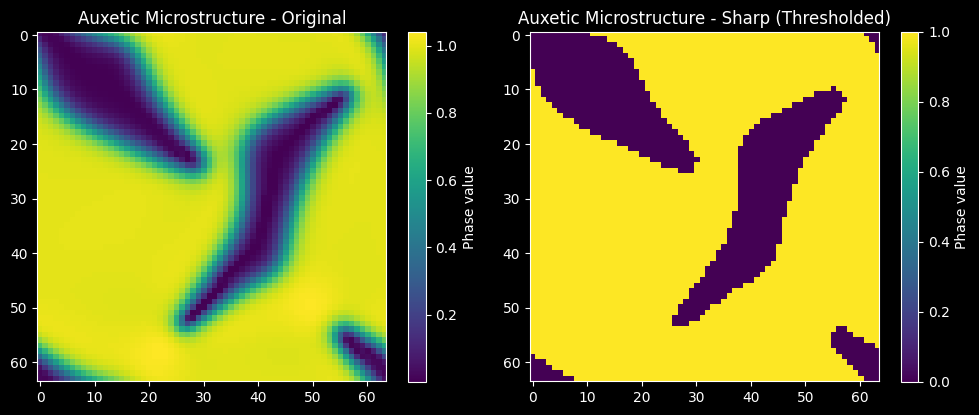

In [19]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(np.abs(geometry), cmap='viridis')
plt.colorbar(label='Phase value')
plt.title('Auxetic Microstructure - Original')

plt.subplot(1, 2, 2)
sharp_geom = np.abs(geometry).copy()
sharp_geom[sharp_geom < 0.5] = 0
sharp_geom[sharp_geom >= 0.5] = 1
plt.imshow(sharp_geom, cmap='viridis')
plt.colorbar(label='Phase value')
plt.title('Auxetic Microstructure - Sharp (Thresholded)')

plt.tight_layout()
plt.show()

## Simulation Loop
Iterate over sharp/smooth transitions and different phase contrasts.



--- Running: sharp=False ---
Contrast 1e+01: Green=17, Jacobi=223, Green-Jacobi=15
Contrast 1e+02: Green=39, Jacobi=271, Green-Jacobi=25
Contrast 1e+03: Green=80, Jacobi=310, Green-Jacobi=38
Contrast 1e+04: Green=165, Jacobi=339, Green-Jacobi=48
Contrast 1e+05: Green=329, Jacobi=386, Green-Jacobi=59


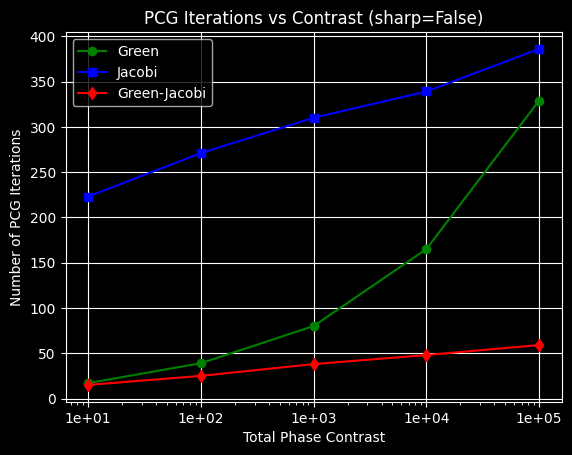


--- Running: sharp=True ---
Contrast 1e+01: Green=23, Jacobi=307, Green-Jacobi=52
Contrast 1e+02: Green=52, Jacobi=410, Green-Jacobi=111
Contrast 1e+03: Green=70, Jacobi=442, Green-Jacobi=140
Contrast 1e+04: Green=69, Jacobi=445, Green-Jacobi=150
Contrast 1e+05: Green=57, Jacobi=445, Green-Jacobi=152


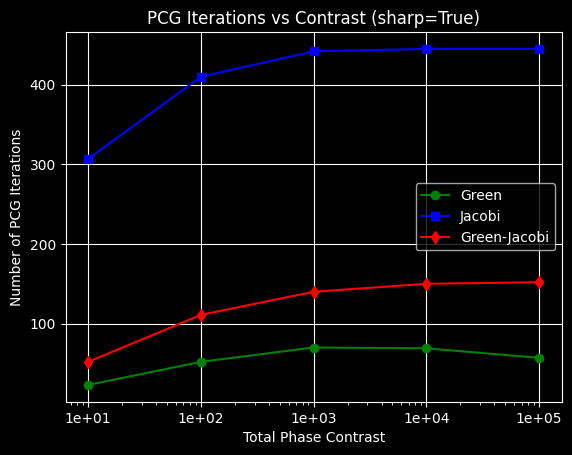

In [20]:
total_phase_contrast_list = [1e1,1e2, 1e3, 1e4, 1e5]

for sharp in [False, True ]:
    nb_it_G = []
    nb_it_J = []
    nb_it_GJ = []

    print(f"\n--- Running: sharp={sharp} ---")

    for total_phase_contrast in total_phase_contrast_list:
        # Initialize phase field from geometry
        phase = np.ones([nb_quad_points_per_pixel, N_x, N_y])
        phase[:, ...] = np.abs(geometry)

        # Apply sharp transition if requested
        if sharp:
            phase = np.where(phase < 0.5, 1 / total_phase_contrast, 1.0)

        # Scale field logarithmically
        phase = scale_field_log10(field=np.copy(phase),
                                  min_val=min(1.0, 1 / total_phase_contrast),
                                  max_val=max(1.0, 1 / total_phase_contrast))

        # Update material data
        mat_data_ijklqxy = np.einsum('ijkl,qxy...', K4_0, phase)

        # Macroscopic loading (10% strain in XX direction)
        macro_grad_ij = np.zeros([n_u_dofs, ndim])
        macro_grad_ij[0, 0] = 1
        E_ijqxy = np.zeros(grad_shape)
        E_ijqxy += macro_grad_ij[(slice(None), slice(None)) + (np.newaxis,) * (len(E_ijqxy.shape) - 2)]

        # Define system matrix operator K(u) and RHS vector b
        K_fun_I = lambda x: Bw_t(ddot42(mat_data_ijklqxy, B(u_ixy=x.reshape(displacement_shape)))).reshape(-1)
        b_I = -Bw_t(ddot42(A=mat_data_ijklqxy, B=E_ijqxy)).reshape(-1)

        # --- Preconditioners ---

        # 1. Green's Preconditioner
        ref_mat_data_ijkl = I4s
        K_ref_fun = lambda x: Bw_t(ddot42(ref_mat_data_ijkl, B(u_ixy=x.reshape(displacement_shape))))

        G_diag_ijxy = np.zeros([n_u_dofs, n_u_dofs, *N])
        for d in range(n_u_dofs):
            unit_impuls_ixy = np.zeros(displacement_shape)
            unit_impuls_ixy[(d,) + ndim * (0,)] = 1
            G_diag_ijxy[:, d, ...] = K_ref_fun(x=unit_impuls_ixy)

        G_diag_ijxy = np.real(fft(x=G_diag_ijxy))
        reshaped_matrices = G_diag_ijxy.reshape(n_u_dofs, n_u_dofs, -1)
        G_batch = reshaped_matrices.transpose(2, 0, 1)
        # Invert each block in Fourier space (skipping the zero frequency mode)
        G_batch[1:, ...] = np.linalg.inv(G_batch[1:, ...])
        M_diag_ijxy = G_batch.transpose(1, 2, 0).reshape(n_u_dofs, n_u_dofs, *N)
        Green_fun_I = lambda x: np.real(ifft(dot21(M_diag_ijxy, fft(x=x.reshape(displacement_shape))))).reshape(-1)

        # 2. Jacobi Preconditioner
        Jacobi_diag_ixy = np.zeros([n_u_dofs, *N])
        for d_i in range(ndim):
            for x_i in range(2):
                for y_i in range(2):
                    comb_impuls_ixy = np.zeros(displacement_shape)
                    comb_impuls_ixy[d_i, x_i::2, y_i::2] = 1.0
                    comb_impuls_ixy = K_fun_I(x=comb_impuls_ixy).reshape(displacement_shape)
                    Jacobi_diag_ixy[d_i, x_i::2, y_i::2] = np.where(
                        comb_impuls_ixy[d_i, x_i::2, y_i::2] != 0.,
                        1 / np.sqrt(comb_impuls_ixy[d_i, x_i::2, y_i::2]), 1.)

        Jacobi_fun = lambda x: Jacobi_diag_ixy * Jacobi_diag_ixy * x.reshape(displacement_shape)

        # 3. Green-Jacobi Preconditioner
        GreenJacobi_fun = lambda x: (Jacobi_diag_ixy * Green_fun_I(Jacobi_diag_ixy * x.reshape(displacement_shape)).reshape(displacement_shape))

        # --- Solvers ---

        # Solver with Green Preconditioner
        res_G = []
        def cb_G(xk): res_G.append(np.linalg.norm(b_I - K_fun_I(xk)))
        _, _ = sc.sparse.linalg.cg(sp.LinearOperator((ndof, ndof), K_fun_I), b_I, M=sp.LinearOperator((ndof, ndof), Green_fun_I), atol=1e-6, callback=cb_G)
        n_G = len(res_G)
        nb_it_G.append(n_G)

        # Solver with Jacobi Preconditioner
        res_J = []
        def cb_J(xk): res_J.append(np.linalg.norm(b_I - K_fun_I(xk)))
        _, _ = sc.sparse.linalg.cg(sp.LinearOperator((ndof, ndof), K_fun_I), b_I, M=sp.LinearOperator((ndof, ndof), Jacobi_fun), atol=1e-6, callback=cb_J)
        n_J = len(res_J)
        nb_it_J.append(n_J)

        # Solver with Green-Jacobi Preconditioner
        res_GJ = []
        def cb_GJ(xk): res_GJ.append(np.linalg.norm(b_I - K_fun_I(xk)))
        _, _ = sc.sparse.linalg.cg(sp.LinearOperator((ndof, ndof), K_fun_I), b_I, M=sp.LinearOperator((ndof, ndof), GreenJacobi_fun), atol=1e-6, callback=cb_GJ)
        n_GJ = len(res_GJ)
        nb_it_GJ.append(n_GJ)

        print(f'Contrast {total_phase_contrast:.0e}: Green={n_G}, Jacobi={n_J}, Green-Jacobi={n_GJ}')

    # Plot results for current 'sharp' setting
    plt.figure()
    plt.semilogx(total_phase_contrast_list, nb_it_G, 'o-', label='Green',color='g')
    plt.semilogx(total_phase_contrast_list, nb_it_J, 's-', label='Jacobi',color='b')
    plt.semilogx(total_phase_contrast_list, nb_it_GJ, 'd-', label='Green-Jacobi',color='r')
    plt.title(f'PCG Iterations vs Contrast (sharp={sharp})')
    plt.xlabel('Total Phase Contrast')
    plt.ylabel('Number of PCG Iterations')
    plt.xticks(total_phase_contrast_list, [f'{c:.0e}' for c in total_phase_contrast_list])
    plt.legend()
    plt.grid(True, which="major", ls="-")
    plt.savefig(f'../figures/sharp_vs_smooth_contrast_sharp_{sharp}.png')
    plt.show()
